In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
sys.path.append('./data/')
sys.path.append('./models/')

from thmodel import *
import pickle
with open('./data/dict_data_final.pkl', 'rb') as f:
    data = pickle.load(f)

__, y = data['Beneixama']
x = pd.read_csv('data_beneixama.csv', index_col=0)
x['Train'] = __['Train'].values

In [27]:
list_P = [
    [0, 0.1, 0.5, 0.9, 1.01],
    [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.01],
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.01],
]
list_alpha = [0.5, 1, 1.5]
list_beta = [0.5, 1, 1.5]
list_gamma = [0.5, 1, 1.5]

In [28]:
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score, fbeta_score, accuracy_score, cohen_kappa_score, matthews_corrcoef

In [29]:
Y = (y[:, :, -1] != 0)*1
columnas = ['alpha', 'beta', 'gamma', 'fp', 'fn', 'acc_b', 'acc', 'f0.5', 'f1', 'f2', 'kappa', 'mcc', 'mean C']

In [30]:
data_metrics = np.zeros((len(list_P), len(list_alpha)*len(list_beta)*len(list_gamma), 13))

for i, part in enumerate(list_P):
    cont = 0
    for a in list_alpha:
        for b in list_beta:
            for c in list_gamma:
                
                grid = Grid(x=x, y=y)
                grid.initialize(part=part)
                grid.compute_th_param(alpha=a, beta=b, gamma=c)
                grid.submatrix()
                grid.enlargement_process()
                grid.montecarlo(n_it=100)

                X = (grid.X[:, :, -1].numpy() != 0)*1

                cmat = confusion_matrix(Y.flatten(), X.flatten(), normalize='true')*100
                fp = cmat[0, 1]
                fn = cmat[1, 0]
                acc_b = balanced_accuracy_score(Y.flatten(), X.flatten())*100
                acc = accuracy_score(Y.flatten(), X.flatten())*100
                f0 = fbeta_score(Y.flatten(), X.flatten(), beta=0.5)*100
                f1 = f1_score(Y.flatten(), X.flatten())*100
                f2 = fbeta_score(Y.flatten(), X.flatten(), beta=2)*100
                kappa = cohen_kappa_score(Y.flatten(), X.flatten())*100
                mcc = matthews_corrcoef(Y.flatten(), X.flatten())*100

                data_metrics[i, cont, :] = [a, b, c, fp, fn, acc_b, acc, f0, f1, f2, kappa, mcc, grid.div.mean().item()]
                print('j:   ', cont, 'Mean C:  ', grid.div.mean().item())
                print('Acc Balanced:  ', acc_b)
                print('Acc:  ', acc)
                print('Kappa:  ', kappa)
                print('MCC:  ', mcc)

                cont += 1



    df = pd.DataFrame(data_metrics[i, :, :], columns=columnas).round(2)
    # columns alpha and beta as row index
    df = df.set_index(['alpha', 'beta', 'gamma'])
    df.to_csv('tables\metrics_part_' + str(i) + '_th.csv')

j:    0 Mean C:   1.4519623517990112
Acc Balanced:   79.8964167862452
Acc:   97.77740768217535
Kappa:   54.03364222058434
MCC:   54.31040060950851
j:    1 Mean C:   1.903924584388733
Acc Balanced:   77.9064881170392
Acc:   98.02873624127541
Kappa:   55.30043597926861
MCC:   55.30299120532906
j:    2 Mean C:   2.355886936187744
Acc Balanced:   75.36429327249927
Acc:   98.1710548229345
Kappa:   54.791146671951466
MCC:   54.98469347346236
j:    3 Mean C:   3.51134991645813
Acc Balanced:   71.24854112509037
Acc:   98.27855077291102
Kappa:   51.892954887919764
MCC:   53.34119256723516
j:    4 Mean C:   6.02269983291626
Acc Balanced:   65.80777917910349
Acc:   98.3194295144514
Kappa:   45.11566448725544
MCC:   50.434429902704835
j:    5 Mean C:   8.534049034118652
Acc Balanced:   62.21951085213235
Acc:   98.22858786658391
Kappa:   37.61057692268878
MCC:   45.5522492406072
j:    6 Mean C:   15.751486778259277
Acc Balanced:   59.941540292394855
Acc:   98.17559690532786
Kappa:   32.258919440793

In [31]:
df1 = pd.read_csv('tables\metrics_part_0_th.csv', index_col=[0, 1, 2])
df2 = pd.read_csv('tables\metrics_part_1_th.csv', index_col=[0, 1, 2])
df3 = pd.read_csv('tables\metrics_part_2_th.csv', index_col=[0, 1, 2])

In [32]:
df2

fp     fn  acc_b    acc   f0.5     f1     f2  kappa  \
alpha beta gamma                                                          
0.5   0.5  0.5    5.62  13.41  90.48  94.20  30.26  40.03  59.09  37.89   
           1.0    3.82  18.70  88.74  95.84  37.15  46.65  62.68  44.89   
           1.5    2.48  28.18  84.67  96.94  43.69  51.21  61.86  49.76   
      1.0  0.5    1.25  43.50  77.63  97.81  51.94  53.56  55.29  52.45   
           1.0    0.32  63.55  68.07  98.27  60.42  48.47  40.46  47.68   
           1.5    0.12  72.70  63.59  98.25  59.13  41.14  31.55  40.49   
      1.5  0.5    0.05  79.81  60.07  98.16  53.14  32.96  23.89  32.41   
           1.0    0.01  84.96  57.52  98.10  46.64  26.09  18.11  25.65   
           1.5    0.00  86.86  56.57  98.06  43.00  23.22  15.90  22.82   
1.0   0.5  0.5    6.32  14.30  89.69  93.50  27.66  37.08  56.22  34.80   
           1.0    6.29  14.02  89.84  93.54  27.83  37.29  56.48  35.01   
           1.5    6.20  13.96  89.92  93.62  28.13  37.62  56.80  35.37   
      1.0  0.5    5.49  15.24  89.63  94.29  30.27  39.89  58.45  37.76   
           1.0    4.10  17.95  88.97  95.59  35.81  45.41  62.03  43.58   
           1.5    3.02  23.78  86.60  96.52  40.86  49.46  62.66  47.89   
      1.5  0.5    1.82  36.18  81.00  97.41  47.33  52.41  58.71  51.12   
           1.0    0.61  55.96  71.71  98.15  57.46  51.57  46.77  50.65   
           1.5    0.24  66.53  66.62  98.28  60.72  46.52  37.70  45.78   
1.5   0.5  0.5    6.27  14.70  89.51  93.54  27.71  37.11  56.14  34.83   
           1.0    6.29  14.63  89.54  93.52  27.68  37.08  56.12  34.79   
           1.5    6.29  14.57  89.57  93.53  27.70  37.10  56.17  34.82   
      1.0  0.5    6.27  14.50  89.62  93.55  27.78  37.19  56.27  34.92   
           1.0    6.17  14.91  89.46  93.63  27.98  37.39  56.34  35.13   
           1.5    6.03  14.84  89.57  93.78  28.47  37.95  56.86  35.71   
      1.5  0.5    5.25  16.19  89.28  94.50  30.93  40.52  58.71  38.43   
           1.0    4.24  17.48  89.14  95.46  35.20  44.85  61.76  42.99   
           1.5    3.37  20.87  87.88  96.23  39.29  48.43  63.13  46.78   

                    mcc  mean C  
alpha beta gamma                 
0.5   0.5  0.5    45.62    1.45  
           1.0    50.00    1.90  
           1.5    52.09    2.36  
      1.0  0.5    52.52    3.51  
           1.0    50.60    6.02  
           1.5    47.15    8.53  
      1.5  0.5    42.09   15.75  
           1.0    38.06   30.50  
           1.5    35.80   45.25  
1.0   0.5  0.5    43.02    1.08  
           1.0    43.24    1.16  
           1.5    43.53    1.24  
      1.0  0.5    45.14    1.45  
           1.0    49.13    1.89  
           1.5    51.37    2.34  
      1.5  0.5    52.00    3.65  
           1.0    51.44    6.31  
           1.5    49.83    8.96  
1.5   0.5  0.5    42.96    1.01  
           1.0    42.95    1.03  
           1.5    42.98    1.04  
      1.0  0.5    43.07    1.08  
           1.0    43.16    1.16  
           1.5    43.63    1.24  
      1.5  0.5    45.48    1.48  
           1.0    48.76    1.96  
           1.5    51.05    2.44

In [33]:
aux = df2[df2['mean C'] <= 3]
aux = aux.drop(['acc'], axis=1)
print(aux.to_latex())

\begin{tabular}{lllrrrrrrrrr}
\toprule
    &     &     &    fp &     fn &  acc\_b &   f0.5 &     f1 &     f2 &  kappa &    mcc &  mean C \\
alpha & beta & gamma &       &        &        &        &        &        &        &        &         \\
\midrule
0.5 & 0.5 & 0.5 &  5.62 &  13.41 &  90.48 &  30.26 &  40.03 &  59.09 &  37.89 &  45.62 &    1.45 \\
    &     & 1.0 &  3.82 &  18.70 &  88.74 &  37.15 &  46.65 &  62.68 &  44.89 &  50.00 &    1.90 \\
    &     & 1.5 &  2.48 &  28.18 &  84.67 &  43.69 &  51.21 &  61.86 &  49.76 &  52.09 &    2.36 \\
1.0 & 0.5 & 0.5 &  6.32 &  14.30 &  89.69 &  27.66 &  37.08 &  56.22 &  34.80 &  43.02 &    1.08 \\
    &     & 1.0 &  6.29 &  14.02 &  89.84 &  27.83 &  37.29 &  56.48 &  35.01 &  43.24 &    1.16 \\
    &     & 1.5 &  6.20 &  13.96 &  89.92 &  28.13 &  37.62 &  56.80 &  35.37 &  43.53 &    1.24 \\
    & 1.0 & 0.5 &  5.49 &  15.24 &  89.63 &  30.27 &  39.89 &  58.45 &  37.76 &  45.14 &    1.45 \\
    &     & 1.0 &  4.10 &  17.95 &  88.97 &  3

In [34]:
print(aux.mean(axis=0).round(2))

fp         5.20
fn        16.79
acc_b     89.01
f0.5      31.91
f1        41.24
f2        58.76
kappa     39.19
mcc       45.95
mean C     1.52
dtype: float64


In [35]:
df2['acc_b'][df2['mean C'] <= 3].max(), df2['mcc'][df2['mean C'] <= 3].mean(), df2['kappa'][df2['mean C'] <= 3].mean()

(90.48, 45.95444444444444, 39.1861111111111)

In [36]:
df2['fp'][df2['mean C'] <= 3].mean(), df2['fn'][df2['mean C'] <= 3].mean() 

(5.195555555555555, 16.790555555555557)

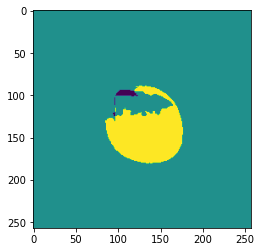

In [37]:
grid = Grid(x=x, y=y)
grid.initialize(part=list_P[2])
grid.compute_th_param(alpha=1., beta=1., gamma=1.5)
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

X = (grid.X[:, :, -1].numpy() != 0)*1

plt.imshow(X-Y)

<AxesSubplot:>

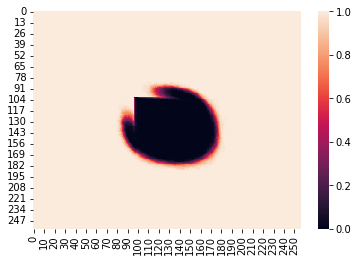

In [38]:
sns.heatmap(grid.X0[:, :, -1].numpy())

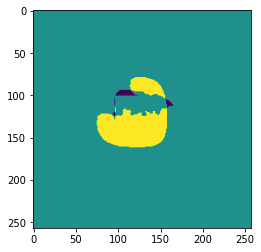

In [39]:
grid = Grid(x=x, y=y)
grid.initialize(part=list_P[1])
grid.compute_th_param(alpha=0.5, beta=0.5, gamma=0.5)
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

X = (grid.X[:, :, -1].numpy() != 0)*1

plt.imshow(X-Y)

<AxesSubplot:>

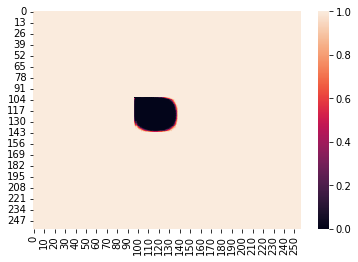

In [40]:
sns.heatmap(grid.X0[:, :, -10].numpy())

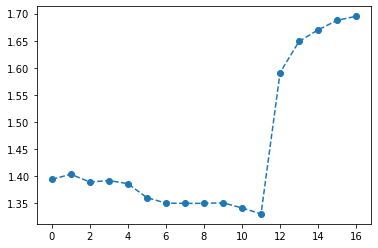

In [41]:
plt.plot(grid.div.numpy(), '--', marker='o')

# Evolución

In [42]:
grid = Grid(x=x, y=y)
grid.initialize(part=list_P[1])
grid.compute_th_param(alpha=0.5, beta=0.5, gamma=0.5)
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

In [43]:
grid_g = Grid(x=x, y=y, mode='gumbel')
grid_g.initialize(part=list_P[1])
grid_g.compute_th_param(alpha=0.5, beta=0.5, gamma=0.5)
grid_g.submatrix()
grid_g.enlargement_process()
grid_g.montecarlo(n_it=100)

In [44]:
sus_X = np.array([(grid.X[:, :, i] != 0).sum().item() for i in range(grid.X.shape[2])])
sus_X_g = np.array([(grid_g.X[:, :, i] != 0).sum().item() for i in range(grid_g.X.shape[2])])
sus_y = np.array([(grid.y[:, :, i] != 0).sum().item() for i in range(grid.y.shape[2])])

abs_X = range(len(sus_X))
abs_y = np.argwhere(x.Train.values == True).flatten()

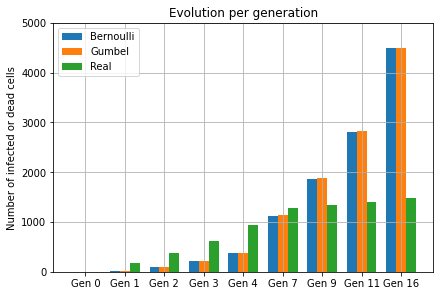

In [45]:
mode = ['Gen ' + str(i) for i in abs_y]
values = {
    'Bernoulli': sus_X[abs_y],
    'Gumbel': sus_X_g[abs_y],
    'Real': sus_y
}

x_ = np.arange(len(mode))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x_ + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of infected or dead cells')
ax.set_title('Evolution per generation')
ax.set_xticks(x_ + width, mode)
ax.legend(loc='upper left')
ax.set_ylim(0, 5000)
ax.grid()

plt.show()

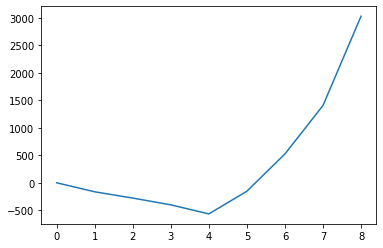

In [46]:
plt.plot(sus_X[abs_y] - sus_y)

In [47]:
sus_X[abs_y] - sus_y

array([   0, -164, -278, -401, -566, -153,  524, 1405, 3027])

In [48]:
grid = Grid(x=x, y=y)
grid.initialize(part=list_P[2])
grid.compute_th_param(alpha=1., beta=1., gamma=1.5)
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

grid_g = Grid(x=x, y=y, mode='gumbel')
grid_g.initialize(part=list_P[2])
grid_g.compute_th_param(alpha=1., beta=1., gamma=1.5)
grid_g.submatrix()
grid_g.enlargement_process()
grid_g.montecarlo(n_it=100)

sus_X = np.array([(grid.X[:, :, i] != 0).sum().item() for i in range(grid.X.shape[2])])
sus_X_g = np.array([(grid_g.X[:, :, i] != 0).sum().item() for i in range(grid_g.X.shape[2])])
sus_y = np.array([(grid.y[:, :, i] != 0).sum().item() for i in range(grid.y.shape[2])])

abs_X = range(len(sus_X))
abs_y = np.argwhere(x.Train.values == True).flatten()

mode = ['Gen ' + str(i) for i in abs_y]
values = {
    'Bernoulli': sus_X[abs_y],
    'Gumbel': sus_X_g[abs_y],
    'Real': sus_y
}

x_ = np.arange(len(mode))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

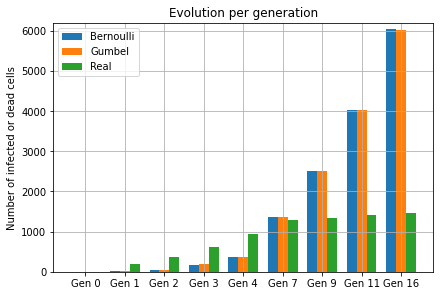

In [49]:
fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x_ + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of infected or dead cells')
ax.set_title('Evolution per generation')
ax.set_xticks(x_ + width, mode)
ax.legend(loc='upper left')
ax.set_ylim(0, 6200)
ax.grid()

plt.show()

In [50]:
sus_X[abs_y] - sus_y

array([   0, -174, -316, -434, -573,   93, 1164, 2627, 4558])

In [51]:
grid.div

tensor([1.9296, 1.9746, 1.9066, 1.9192, 1.8924, 1.7766, 1.7337, 1.7317, 1.7317,
        1.7357, 1.6967, 1.6522, 3.0952, 3.5253, 3.6937, 3.8364, 3.8996])

# Table to latex

In [52]:
latex_formatted = df2.to_latex(header=False)
print(latex_formatted)

\begin{tabular}{lllrrrrrrrrrr}
\toprule
    &     &     &  5.62 &  13.41 &  90.48 &  94.20 &  30.26 &  40.03 &  59.09 &  37.89 &  45.62 &   1.45 \\
alpha & beta & gamma &  3.82 &  18.70 &  88.74 &  95.84 &  37.15 &  46.65 &  62.68 &  44.89 &  50.00 &   1.90 \\
0.5 & 0.5 & 0.5 &  2.48 &  28.18 &  84.67 &  96.94 &  43.69 &  51.21 &  61.86 &  49.76 &  52.09 &   2.36 \\
    &     & 1.0 &  1.25 &  43.50 &  77.63 &  97.81 &  51.94 &  53.56 &  55.29 &  52.45 &  52.52 &   3.51 \\
    &     & 1.5 &  0.32 &  63.55 &  68.07 &  98.27 &  60.42 &  48.47 &  40.46 &  47.68 &  50.60 &   6.02 \\
    & 1.0 & 0.5 &  0.12 &  72.70 &  63.59 &  98.25 &  59.13 &  41.14 &  31.55 &  40.49 &  47.15 &   8.53 \\
    &     & 1.0 &  0.05 &  79.81 &  60.07 &  98.16 &  53.14 &  32.96 &  23.89 &  32.41 &  42.09 &  15.75 \\
    &     & 1.5 &  0.01 &  84.96 &  57.52 &  98.10 &  46.64 &  26.09 &  18.11 &  25.65 &  38.06 &  30.50 \\
    & 1.5 & 0.5 &  0.00 &  86.86 &  56.57 &  98.06 &  43.00 &  23.22 &  15.90 &  22.82 &  3